<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GradientBoostingRegressor question sur le gradient
pas compris elastic net ... car comment choisir ?
alors que le lasso en prend 1 au hasard
eslascticnetCV useful ?

CE2 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle). ??

# **Introduction**

---

## **Prérequis**
- Télécharger [dataset nettoyé](https://drive.google.com/file/d/1-EuzI1ibLAG_1brg_v3MKcDtEgKDFIdl/view?usp=drive_link) dans Google Drive
- Modifier le chemin du fichier dans le code


---

---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions auxiliaires**

### **III. Prédiction de la variable TotalGHGEmissions**
**A. Entrainement du premier modèle: régression linéaire**

# **I. Installation et mise en place de l'environnement de travail**

In [ ]:
# importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

import datetime

from google.colab import drive

In [ ]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-05-18T17:59:08.594827


In [ ]:
# configurations de l'affichages des données
pd.set_option('display.max_columns', None)

In [ ]:
# connexion au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# vérification de l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')
df.head(2)

,OSEBuildingID,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified
0,1,DOWNTOWN,1.0,12,88434,0,88434,Hotel,88434.0,missing,0.0,missing,0.0,60.0,7226362.5,2003882.0,3946027.0,1276453.0,249.98,89,0.0,0
1,2,DOWNTOWN,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8387933.0,0.0,3242851.0,5145082.0,295.86,20,0.0,0


In [ ]:
# vérification des données
df.isna().sum(axis=0)

OSEBuildingID                      0
Neighborhood                       0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
Electricity(kBtu)                  0
NaturalGas(kBtu)                   0
TotalGHGEmissions                  0
BuildingAge                        0
LastYearENERGYSTARCertified        0
NbYearENERGYSTARCertified          0
dtype: int64

# **II. Définitions des fonctions et des variables globales**


Les principaux algorithmes du machine learning supervisé sont les suivants : forêts aléatoires (plusieurs arbres de décisions), arbres de décision, algorithme K-NN (k-Nearest Neighbors) (qui se ressemble.. est identique), régression linéaire, algorithme de Naïve Bayes??, machine à vecteurs de support (SVM)??, régression logistique (hum ?) et boosting de gradient (minimisation de la fonction de coût)

# **III. TARGET 1**

## Suppression des modalités représentant moins de 5% du dataset

In [ ]:
# Vérifier s'il y a assez de bâtiments par modalités catégorielles

# Obtenir le nombre d'occurrences de chaque modalité
modalities_counts = df['Neighborhood'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
Neighborhood
DOWNTOWN                 338
GREATER DUWAMISH         319
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    137
EAST                     110
NORTHEAST                 99
NORTHWEST                 74
BALLARD                   62
NORTH                     57
CENTRAL                   42
DELRIDGE                  38
SOUTHWEST                 31
SOUTHEAST                 30
Name: count, dtype: int64
Neighborhood
DOWNTOWN                 0.228997
GREATER DUWAMISH         0.216125
LAKE UNION               0.094173
MAGNOLIA / QUEEN ANNE    0.092818
EAST                     0.074526
NORTHEAST                0.067073
NORTHWEST                0.050136
BALLARD                  0.042005
NORTH                    0.038618
CENTRAL                  0.028455
DELRIDGE                 0.025745
SOUTHWEST                0.021003
SOUTHEAST                0.020325
Name: count, dtype: float64


In [ ]:
# Seuil de 5%
threshold = 0.05 * df.shape[0]

# Transformer en 'OTHER' pour les valeurs représentant moins de 5%
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x if modalities_counts[x] > threshold else 'OTHER')

In [ ]:
# Vérifier s'il y a assez de bâtiments par modalités catégorielles

# Obtenir le nombre d'occurrences de chaque modalité
modalities_counts = df['LargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
LargestPropertyUseType
Office                                                  484
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    88
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              38
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    28
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                 

In [ ]:
# Transformer en 'Other' pour les valeurs représentant moins de 5%
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(lambda x: x if modalities_counts[x] > threshold else 'Other')

In [ ]:
# Vérifier s'il y a assez de bâtiments par modalités catégorielles

# Obtenir le nombre d'occurrences de chaque modalité
modalities_counts = df['SecondLargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])
df.drop(columns=['SecondLargestPropertyUseType'], inplace=True) #pas besoin pour l'entrainement des modèles
df.drop(columns=['SecondLargestPropertyUseTypeGFA'], inplace=True) #pas besoin pour l'entrainement des modèles

Nombre d'occurrences de chaque modalité :
SecondLargestPropertyUseType
missing                                                 665
Parking                                                 321
Office                                                  160
Retail Store                                             82
Other                                                    43
Restaurant                                               28
Non-Refrigerated Warehouse                               28
Fitness Center/Health Club/Gym                           16
Data Center                                              12
Other - Services                                         11
Multifamily Housing                                      11
Medical Office                                            8
Bank Branch                                               7
Distribution Center                                       7
Laboratory                                                6
Supermarket/Grocery Store    

In [ ]:
# Vérifier s'il y a assez de bâtiments par modalités catégorielles

# Obtenir le nombre d'occurrences de chaque modalité
modalities_counts = df['ThirdLargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])
df.drop(columns=['ThirdLargestPropertyUseType'], inplace=True) #pas besoin pour l'entrainement des modèles
df.drop(columns=['ThirdLargestPropertyUseTypeGFA'], inplace=True)

Nombre d'occurrences de chaque modalité :
ThirdLargestPropertyUseType
missing                                                 1148
Office                                                    48
Retail Store                                              43
Parking                                                   40
Other                                                     38
Restaurant                                                30
Non-Refrigerated Warehouse                                13
Data Center                                               13
Multifamily Housing                                       11
Swimming Pool                                             10
Medical Office                                             9
Pre-school/Daycare                                         8
Food Service                                               7
Bank Branch                                                5
Other - Restaurant/Bar                                     5
Social/Meeting 

In [ ]:
df.drop(columns=['OSEBuildingID'], inplace=True) #pas besoin pour l'entrainement des modèles

TARGET = 'TotalGHGEmissions'
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'BuildingAge', 'LastYearENERGYSTARCertified',
       'NbYearENERGYSTARCertified']
CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET]
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [ ]:
df1 = df.copy()

**Trouver les variables prédictifs à l'aide du lasso ? To do si le temps**

##**A. Entrainement d'un modèle linéaire: LinearRegression**

In [ ]:
# importation des librairies
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

In [ ]:
# séparation des variables explicatives de la variable à prédire
df1 = df.copy()
y = df1.pop(TARGET)
X = df1

In [ ]:
# features engineering
y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__fit_intercept' : [False, True]#,
    #'regressor__positive'      : [False, True]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_LR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_LR.score(X_test, y_test).round(3)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__fit_intercept': True}
Moyenne des scores: -83636886171844.66
----------------
Score sur le train : 0.943
Score sur le test : 0.946


##**B. Entrainement d'un modèle linéaire: RandomForestRegressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__n_estimators'  : [100, 500]#,
    # 'regressor__max_depth'     : [2, 3, 4, 5],
    # 'regressor__criterion'     : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    # 'regressor__min_samples_split' : [2, 10, 100]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_RFR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_RFR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_RFR.score(X_test, y_test).round(3)}')
mean_time_RFR = gs.cv_results_['mean_fit_time'].mean().round(2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__n_estimators': 500}
Moyenne des scores: 0.98
----------------
Score sur le train : 0.998
Score sur le test : 0.997


##**C. Entrainement d'un modèle linéaire: GradientBoostingRegressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__learning_rate'      : [0.1, 0.05, 0.5, 1]#,
    # 'regressor__n_estimators'       : [100, 50, 200, 300],
    # 'regressor__max_depth'          : [3, 2, 4, 5],
    # 'regressor__min_samples_split'  : [2, 3, 4],
    # 'regressor__min_samples_leaf'   : [1, 2, 3],
    # 'regressor__loss'               : ["squared_error", "absolute_error", "huber", "quantile"]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_GBR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_GBR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_GBR.score(X_test, y_test).round(3)}')
mean_time_GBR = gs.cv_results_['mean_fit_time'].mean().round(2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres: {'regressor__learning_rate': 0.1}
Moyenne des scores: 0.978
----------------
Score sur le train : 0.998
Score sur le test : 0.995


##**D. Entrainement d'un modèle linéaire: SVR**

In [ ]:
from sklearn.svm import SVR

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__kernel'          : ['rbf', 'poly'], #, 'linear', 'poly', 'sigmoid', 'precomputed'], #passer dans les dimensions supérieures
    #'regressor__degree'         : [3, 2, 4, 5] #for poly
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_SVR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_SVR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_SVR.score(X_test, y_test).round(3)}')
mean_time_SVR = gs.cv_results_['mean_fit_time'].mean().round(2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__kernel': 'rbf'}
Moyenne des scores: 0.915
----------------
Score sur le train : 0.959
Score sur le test : 0.956


##**E. Entrainement d'un modèle linéaire: ElasticNet**

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__alpha'          : [1.0, 0.5, 1.5],
    'regressor__l1_ratio'       : [0.5, 0.25, 0.75],
    #'regressor__max_iter'       : [1000, 500]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_EN = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_EN.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_EN.score(X_test, y_test).round(3)}')
mean_time_EN = gs.cv_results_['mean_fit_time'].mean().round(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleurs hyperparamètres: {'regressor__alpha': 0.5, 'regressor__l1_ratio': 0.75}
Moyenne des scores: 0.763
----------------
Score sur le train : 0.764
Score sur le test : 0.775


## Choix de l'algorithme:

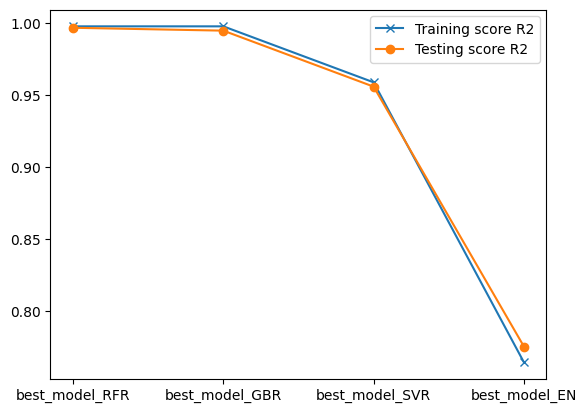

In [ ]:
# visualisation des scores des différents modèles

models        = ['best_model_RFR','best_model_GBR', 'best_model_SVR', 'best_model_EN']
train_scrore  = [best_model_RFR.score(X_train, y_train).round(3), best_model_GBR.score(X_train, y_train).round(3), best_model_SVR.score(X_train, y_train).round(3), best_model_EN.score(X_train, y_train).round(3)]
test_score    = [best_model_RFR.score(X_test, y_test).round(3), best_model_GBR.score(X_test, y_test).round(3), best_model_SVR.score(X_test, y_test).round(3), best_model_EN.score(X_test, y_test).round(3)]

plt.plot(models, train_scrore, label='Training score R2', marker='x')
plt.plot(models, test_score, label='Testing score R2', marker='o')

plt.legend()
plt.show()

Les 2 meilleurs modèles sont le RandomForestRegressor et le GradientBoostingRegressor: Le score atteint quasiment 1 et il n'y a pas de problème d'overfitting.

Pour choisir le modèle, je vais m'intéresser au temps d'entrainement.

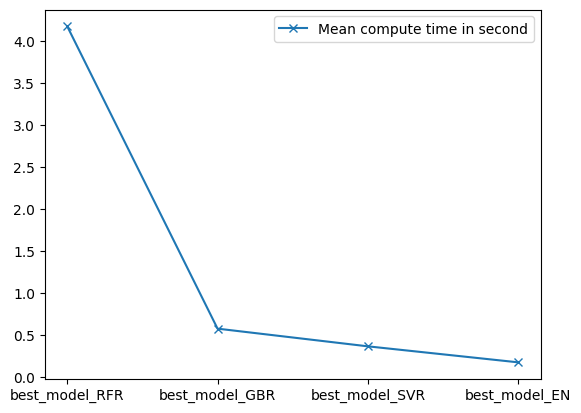

In [ ]:
# visualisation du temps de computage
mean_process_time = [mean_time_RFR, mean_time_GBR, mean_time_SVR, mean_time_EN]
plt.plot(models, mean_process_time, label='Mean compute time in second', marker='x')

plt.legend()
plt.show()

Le modèle RandomForestRegressor prend en moyenne 7 fois plus de temps à entrainer que le modèle GradientBoostingRegressor.

Pour notre jeu de données, cette différence est insignifiante. Il n'y a que 1476 observations.

Néanmoins, si le jeu de données comporte davantage de données, cela pourra augmenter considérablement le temps de calcul.
Pour ces raisons, je vais choisir GradientBoostingRegressor comme modèle final.

In [ ]:
best_model_pipeline = best_model_GBR
best_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder_nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('norma', PowerTransformer(),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEnergyUse(kBtu)',
                                                   'SteamUse(kBtu)',
                                                   'Electricity(kBtu)',
                                                   'NaturalGas(kBtu)',
                                                   'BuildingAge',
                                                   'LastYearENERGYSTARCertified',
                                                   'NbYearENERGYSTARCertified'])])),
                ('regressor', GradientBoostingRegressor())])

In [ ]:
best_model = best_model_pipeline[1]
print('hyperparameters of GradientBoostingRegressor:')
best_model.get_params()

hyperparameters of GradientBoostingRegressor:


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# **IV. Analyse des variables explicatives du modèle**

In [ ]:
!pip install shap
import shap
shap.initjs()

In [ ]:
df_model = df.copy()
y = df_model.pop(TARGET)
X = df_model

y_transformed = np.log(y + 1)
X_transformed = preprocessor.fit_transform(X)
explainer = shap.Explainer(best_model)
shap_values = explainer(X_transformed)
np.shape(shap_values.values)

(1476, 27)

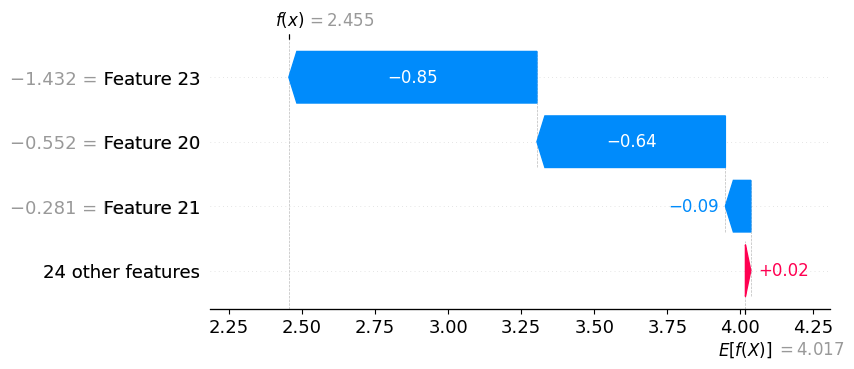

In [ ]:
shap.plots.waterfall(shap_values[1000], max_display=4)

In [ ]:
shap.initjs()
shap.plots.force(shap_values[1000])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0:1476])

In [ ]:
# Récupérer les noms des colonnes après transformation
ohe_feature_names = preprocessor.named_transformers_['encoder_nominal'].get_feature_names_out(CAT_FEATURES)
final_feature_names = np.concatenate([ohe_feature_names, NUM_FEATURES])

# Créer un DataFrame pour voir les noms des colonnes
X_transformed_df = pd.DataFrame(X_transformed, columns=final_feature_names)

# Afficher les résultats
# print("Noms des colonnes après transformation:\n", final_feature_names)

print(final_feature_names[20])
print(final_feature_names[23])
print(final_feature_names[21])

SiteEnergyUse(kBtu)
NaturalGas(kBtu)
SteamUse(kBtu)


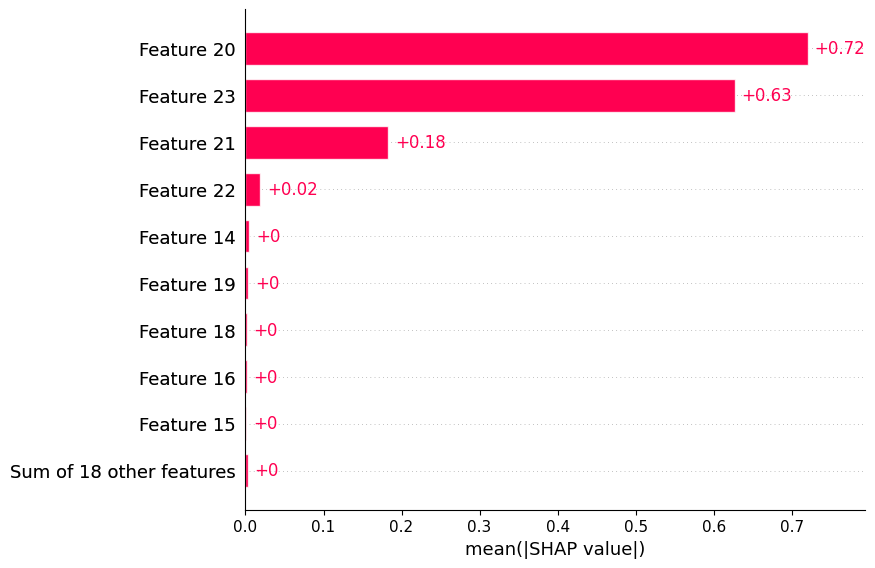

In [ ]:
# Poids de chaque variable
shap.plots.bar(shap_values)

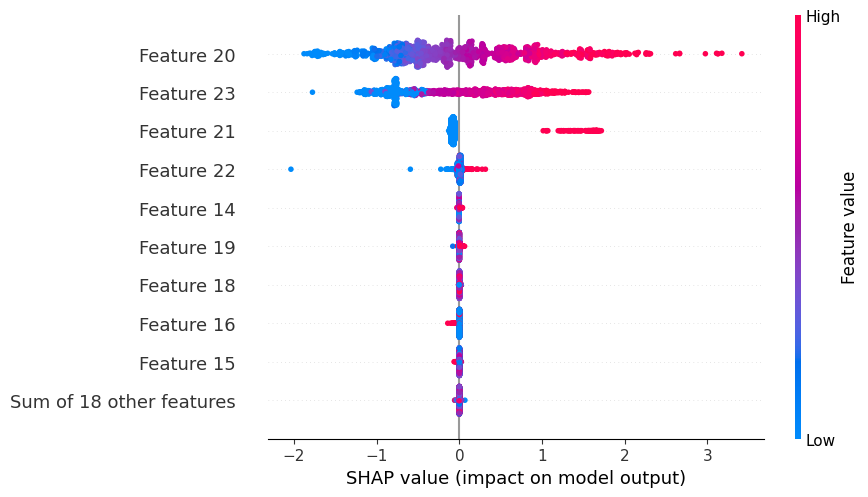

In [ ]:
shap.plots.beeswarm(shap_values)

## Vérifier l'effet de la variable STAR

Préparation des données

In [ ]:
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',
       'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'BuildingAge', 'LastYearENERGYSTARCertified',
       'NbYearENERGYSTARCertified']
CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'ENERGYSTARScore']

In [ ]:
df2 = df.copy()
df2.drop(columns=['ENERGYSTARScore'], inplace=True)

In [ ]:
# features engineering
y = df2.pop(TARGET)
X = df2

y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__n_estimators'  : [100, 500]#,
    # 'regressor__max_depth'     : [2, 3, 4, 5],
    # 'regressor__criterion'     : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    # 'regressor__min_samples_split' : [2, 10, 100]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model.score(X_test, y_test).round(3)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__n_estimators': 500}
Moyenne des scores: 0.98
----------------
Score sur le train : 0.997
Score sur le test : 0.997


##**Entrainement du modèle LASSO**


In [ ]:
# On choisie toutes les variables numériques et 3 variables catégorielles
nb_null_value = df.isna().sum(axis=0)
col_to_keep = nb_null_value[nb_null_value < 100].index.to_list()
num_column = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index.to_list()
cat_to_keep = ['PrimaryPropertyType', 'Neighborhood']
num_to_keep = list(set(col_to_keep).intersection(num_column))
FINAL_COL =  num_to_keep + cat_to_keep #set pour le non itérable, #list pour concat ensuite
FINAL_COL = ['TotalGHGEmissions', 'Electricity(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)'
             , 'NumberofBuildings', 'PrimaryPropertyType', 'Neighborhood']
print((FINAL_COL))

In [ ]:
TARGET = 'TotalGHGEmissions'
FEATURE = [col for col in FINAL_COL if col != TARGET]
df_train = df[FINAL_COL].dropna()
print(FEATURE)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

In [ ]:
# Features engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_to_keep),
         ('norma', PowerTransformer(), ['Electricity(kBtu)', 'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'NumberofBuildings'])
    ],
    remainder='drop'
  )

In [ ]:
pp = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso()),
])

In [ ]:
# On va séparer les variables explicatives de la variable cible.
y = df_train.pop(TARGET)
X = df_train
print(y.shape, X.shape)
# # Question : encodage sur tout le jeu de données ou une partie seulement ? a priori separer puis encoder car pbm de type
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# X_train_df = pd.DataFrame(data=X_train, columns=FEATURE)
# y_train_df = pd.DataFrame(data=y_train, columns=[TARGET])

# model = PowerTransformer()
# y_train_normed = model.fit_transform(y_train_df)
# X_df = pd.DataFrame(data=X, columns=FEATURE)
# y_df = pd.DataFrame(data=y, columns=[TARGET])
pp.fit(X, y)

In [ ]:
# fit model by using grid search
param_grid = {
    'regressor__alpha'          : [0.0001, 0.001, 0.01, 0.10, 1],
    'regressor__fit_intercept'  : [True, False]
}
grid_search = GridSearchCV(pp, param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
grid_search.fit(X, y)
print(grid_search.best_params_)
print('----------------')

# model scoring
best_model = grid_search.best_estimator_
print(f'Model\'s score : {best_model.score(X, y).round(3)}') #est R2 ? Bon va falloir revoir pipeline etc.

In [ ]:
lasso_regressor = best_model.named_steps['regressor']

# Access the coefficients of the Lasso
lasso_coefficients = lasso_regressor.coef_

print("Lasso Coefficients:")
print(lasso_coefficients)

# Print number of total variables and total variables with non null parameter
(
    lasso_coefficients.shape,
    lasso_coefficients[lasso_coefficients != 0.].shape
)
# Le modele a simplifié notre equation: il a choisi seulement 14 variables parmis les 17 !